In [ ]:
# @title Preamble
import os
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.signal
import copy
import time
import matplotlib.pyplot as plt
import scipy.signal
from IPython import display
%matplotlib inline

HOMEDIR="/content/drive/MyDrive/Colab Notebooks/waveforms"

SAMPLE_RATE = 40 # we assume that all of the waveforms have this sample rate

SINGLE_BATCH = False # Make this true for a quick debugging of the dataloaders
if SINGLE_BATCH:
  print("Warning this notebook will only do a quick testing run.")

if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# @title WaveformDataset code
from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    """Waveforms dataset."""

    def __init__(self, df, transform=None):
      """
      Arguments:
          df (Pandas dataframe)
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      torch.manual_seed(42)
      unif = torch.distributions.Uniform(5, 15)
      self.dataset = []
      for idx, row in df.iterrows():
        # offset in 5 to 15 where the signal arrives
        offset = int(unif.sample() * row.sr)
        data = scipy.signal.detrend(row.data)
        start = len(data) // 2  + int(row.td * row.sr) - offset
        end = start + 20 * row.sr
        self.dataset.append((data[start:end], offset, row.sr))
      self.transform = transform

    def __len__(self):
      return len(self.dataset)

    def create_triangle(self, num_points, offset, sr):
      curve = np.zeros(num_points)
      curve[offset - sr // 2: offset] = np.linspace(0, 1, sr // 2)
      curve[offset: offset + sr // 2] = np.linspace(1, 0, sr // 2)
      return curve

    def __getitem__(self, idx):
      waveform, offset, sr = self.dataset[idx]
      signal = self.create_triangle(len(waveform), offset, sr)
      sample = {
          'offset': offset,
          'waveform': torch.from_numpy(waveform),
          'output': torch.from_numpy(signal),
          'sr': sr
      }
      if self.transform:
        sample = self.transform(sample)
      return sample

In [ ]:
# @title Model evaluation and training code
import numpy as np
import torch
import copy
import time
import matplotlib.pyplot as plt
import scipy.signal
from IPython import display
from tqdm.auto import tqdm
import seaborn as sns
sns.set()

SCALE = 10 # scale up the output to exaggerate the loss
criterion = torch.nn.MSELoss()

def eval_model(model, valid_dataloader):
  """
  Evaluates a model using data from the given dataloader

  Parameters
  ----------
  model
    model to be evaluated
  valid_dataloader
    the dataloader containing the data to evaluate the model on

  Returns
  -------
    mean loss
    stddev of loss across batches
    mean error
    stddev of error across samples
  """
  model.eval()
  all_loss, all_errs = [], []
  for idx, batch in enumerate(valid_dataloader):
    waveform = torch.unsqueeze(batch['waveform'], 2).to(DEVICE)
    exp_out = (batch['output'] * SCALE).to(DEVICE)
    with torch.no_grad():
      act_out = model(waveform).squeeze(2)
      loss = criterion(act_out, exp_out)
    all_loss.append(loss.item())
    pred = act_out.to('cpu').argmax(1)
    # calculate the error in terms of seconds
    err = ((pred - batch['output'].argmax(1)) / SAMPLE_RATE).tolist()
    all_errs.extend(err)
    if SINGLE_BATCH and idx > 1:
      break
  return np.mean(all_loss), np.std(all_loss), np.mean(all_errs), np.std(all_errs)

def train_model(
    model,
    train_dataloader,
    valid_dataloader,
    num_epochs,
    save_interval=None,
    model_path=None,
    learning_rate = 0.05,
    eta_plus = 1.2,
    eta_minus = 0.5):
  """
  Train a model for the given number of epochs while adjusting the learning
  rate. This also plots the curves of the loss and accuracy.

  Parameters
  ----------
  learning_rate : float
    initial learning rate
  eta_plus : float
    multiplier for the learning rate if the loss decreases
  eta_minus : float
    multiplier for the learning rate if the loss increases

  Returns
  -------
    the best model that was found during training
  """
  plt.figure(figsize=(12, 4)) # figure for displaying the progress

  # SGD Optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  best_loss, best_model_state = None, None
  all_val_loss, all_val_loss_std, all_val_err, all_val_err_std = [], [], [], []
  all_train_loss, all_train_loss_std = [], []
  all_learning_rate = []
  last_desc = ""
  pbar1 = tqdm(range(num_epochs), total=num_epochs, desc="", leave=True)
  for epoch in pbar1:
    t1 = time.time()
    model.train()
    batch_losses = []
    pbar2 = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="", leave=False)
    for idx, batch in pbar2:
      waveform = torch.unsqueeze(batch['waveform'], 2).to(DEVICE)
      exp_out = (batch['output'] * SCALE).to(DEVICE)
      optimizer.zero_grad()
      act_out = model(waveform).squeeze(2)
      loss = criterion(act_out, exp_out)
      loss.backward()
      batch_losses.append(loss.to("cpu").item())
      pbar2.set_description(last_desc)
      # prevent the loss from exploding by clipping the gradients
      clip = 5
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
      ## print(f"Epoch {epoch:3d} Batch Index {idx:3d} loss {loss.data:.3f}")
      if SINGLE_BATCH and idx > 1:
        break
    # At the end of each epoch compute the train/validation loss and prediction error
    train_loss, train_loss_std = np.mean(batch_losses), np.std(batch_losses)
    val_loss, val_loss_std, val_err, val_err_std = eval_model(model, valid_dataloader)
    t2 = time.time()
    last_desc = "Epoch {} Training loss {:.3f}+-{:.3f} LR {:g} Validation Loss {:.3f}+-{:.3f}"\
    " Predicton Error {:.3f}+-{:.3f} sec Epoch completed in {:.3f} sec".format(
        epoch+1, train_loss, train_loss_std, learning_rate, val_loss, val_loss_std, val_err, val_err_std, t2-t1)
    pbar1.set_description(last_desc)
    # no point continuing if the loss has exploded
    if np.isnan(val_err) or np.isnan(val_loss):
      break
    if best_loss is None or val_loss < best_loss:
      best_model_state = copy.deepcopy(model.state_dict())
      best_loss = val_loss

    if save_interval is not None and model_path is not None and (epoch+1) % save_interval == 0:
      torch.save(model, model_path)

    # update the history
    all_val_loss.append(val_loss)
    all_val_loss_std.append(val_loss_std)
    all_val_err.append(val_err)
    all_val_err_std.append(val_err_std)
    all_learning_rate.append(learning_rate)
    all_train_loss.append(train_loss)
    all_train_loss_std.append(train_loss_std)

    # update the learning rate depending on whether the training loss
    # is improving or not
    if len(all_train_loss) > 1:
      if all_train_loss[-1] < all_train_loss[-2]:
        learning_rate *= eta_plus
      else:
        learning_rate *= eta_minus
      for g in optimizer.param_groups:
        g['lr'] = learning_rate

    # plot the current progress
    plot_training_history(
      all_val_loss,
      all_val_loss_std,
      all_val_err,
      all_val_err_std,
      all_learning_rate,
      all_train_loss,
      all_train_loss_std)

  display.clear_output(wait=True)
  # return the best model that was encountered during training
  model.load_state_dict(best_model_state)
  return model

def plot_training_history(
    all_val_loss,
    all_val_loss_std,
    all_val_err,
    all_val_err_std,
    all_learning_rate,
    all_train_loss,
    all_train_loss_std,
    ):
  x = np.arange(len(all_val_loss)) + 1

  plt.clf()

  ax = plt.subplot(1, 3, 1)
  ax.set_title('Loss')
  ax.set_xlabel("Epoch")
  ax.errorbar(x, all_val_loss, yerr=all_val_loss_std, color='b', alpha=0.9, label='val')
  ax.errorbar(x, all_train_loss, yerr=all_train_loss_std, color='r', alpha=0.9, label='train')
  ax.legend()

  ax = plt.subplot(1, 3, 2, sharex=ax)
  ax.set_title('Error')
  ax.set_xlabel("Epoch")
  ax.errorbar(x, all_val_err, yerr=all_val_err_std, color='b', alpha=0.9)

  ax = plt.subplot(1, 3, 3, sharex=ax)
  ax.set_title('Learning Rate')
  ax.set_xlabel("Epoch")
  ax.plot(x, all_learning_rate, color='k')

  plt.tight_layout()
  display.clear_output(wait=True)
  display.display(plt.gcf())


def bandpass(low_freq, high_freq, sr, data):
  """
  low_freq
  high_freq
  sr - sampling rate
  data - data samples

  Bandpass the signal between the low and high frequency
  """
  # apply a 3-pole bandpass filter
  b, a = scipy.signal.butter(3, [low_freq * 2 /sr, high_freq * 2 / sr], 'band')
  # We use lfilter which is a causal filter that is better suited for onset detection
  # as opposed to filtfilt
  filtered = scipy.signal.lfilter(b, a, data)
  return filtered

def visualize_predictions(model, dataset, skip=0):
  """Visualize model predictions on the first four examples in the dataset.
  If skip is specified then we skip those many samples.
  """
  fig = plt.figure(figsize=(12, 8))

  count = 0
  for i, sample in enumerate(valid_dataset):
    if i < skip:
      continue
    count += 1
    waveform = torch.unsqueeze(sample['waveform'], 1).to(DEVICE)
    with torch.no_grad():
      out = model(waveform).squeeze(2).squeeze(0).to('cpu')
    pred = out.argmax().item()

    ax = plt.subplot(2, 4, count)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.axvline(x = pred, ls = '-', color = 'r', alpha=0.7, zorder=3)
    ax.axvline(x = sample['offset'], ls = ':', color = 'g', alpha=0.7, zorder=2)
    ax.plot(sample['waveform'], color='k', alpha=0.9, zorder=1)

    ax = plt.subplot(2, 4, count + 4, sharex=ax)
    plt.tight_layout()
    ax.set_title('Sample #{} 1-3 Hz'.format(i))

    # plot the output on a separate axis
    ax2 = ax.twinx()
    ax2.plot(out, color='r', alpha=.7, zorder=3)
    ax2.set_yticks(np.arange(11))
    ax2.tick_params(
        axis='y',
        color='r',
        grid_alpha=0,
        bottom=False,
        top=False,
        left=False,
        right=True,
        labeltop=False,
        labelbottom=False,
        labelleft=False,
        labelright=False)

    ax.axis('off')
    filt_waveform = bandpass(1, 3, SAMPLE_RATE, sample['waveform'])
    ax.plot(
        filt_waveform,
        color='k',
        alpha=0.9,
        zorder=1
    )

    ax.axvline(x = sample['offset'], ls = ':', color = 'g', alpha=0.7, zorder=2)


    if count == 4:
      break

  fig.subplots_adjust(hspace=0.06, wspace=0)
  plt.show()
  time.sleep(0.5) # give a few seconds for the plots to show up

In [ ]:
# @title Load datasets from disk and create dataloader (train/valid)
train_dataset = torch.load(os.path.join(HOMEDIR, "train_dataset1.data"))
valid_dataset = torch.load(os.path.join(HOMEDIR, "valid_dataset1.data"))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0)

In [ ]:
# @title MultConvRNNModel (model7)
import torch

class MultConvRNNModel(torch.nn.Module):
  """Multiple convolutions followed by an RNN

  Attributes
  ----------
  kernels
    a Sequential model of all the kernels
  rnn
    an RNN model
  fc
    a fully connected layer
  """
  def __init__(self, input_dim, kernel_dims, hidden_dim, layer_dim, output_dim=1):
    """
    Parameters
    ----------
    input_dim : int
      The number of channels in the waveform, typically this is one.
    kernel_dims : list [int, int]
      a list of (num_kernels, kernel_size) for each convolution, at least one
    hidden_dim : int
      the size of the hidden layer in the RNN
    layer_dim : int
      the number of layers of the RNN
    output_dim : int, optional
      the number of output channels, defaults to 1
    """
    super(MultConvRNNModel, self).__init__()

    next_input_dim = input_dim

    # Multiple Convolutions
    if len(kernel_dims) < 1:
      raise ValueError("kernel_dims must be non-empty")
    self.kernels = torch.nn.Sequential()
    for num_kernels, kernel_size in kernel_dims:
      self.kernels.append(
        torch.nn.Conv1d(
          in_channels=next_input_dim,
          out_channels=num_kernels,
          kernel_size=kernel_size,
          padding='same'
        )
      )
      next_input_dim = num_kernels # the input for the next layer

    # RNN
    self.rnn = torch.nn.RNN(
        input_size = num_kernels,
        hidden_size = hidden_dim,
        num_layers = layer_dim,
        nonlinearity = 'tanh',
        batch_first = True,
        bidirectional = True
    )

    # Readout layer
    self.fc = torch.nn.Linear(
        in_features = 2 * hidden_dim,
        out_features = output_dim
    )

  def forward(self, x):
    """
    Parameters
    ----------
    x : tensor
      a tensor of shape (N, L, C_in) or (L, C_in),
      where N is batch, L is length of sequence and C_in is the input dim
    """
    # if x has shape (L, C_in) then add an extra batch dim (1, L, C_in)
    if len(x.size()) == 2:
      x = x.unsqueeze(0)

    inp = x.permute(0, 2, 1) # inp: N, C_in, L
    out = self.kernels(inp) # out: N, C_out, L  (C_out = number of kernels)
    out = out.permute(0, 2, 1) # out: N, L, C_out
    out, hn = self.rnn(out)
    out = self.fc(out)
    return out


In [ ]:
# @title Train model7 or load from disk
model_path = os.path.join(HOMEDIR, "model7.pic")
if os.path.exists(model_path):
  # model7 = torch.load(model_path)
  model7 = torch.load(model_path, map_location=torch.device(DEVICE))
else:
  model7 = MultConvRNNModel(
    input_dim=1,
    # https://www.nature.com/articles/s41467-020-17591-w/figures/1
    kernel_dims=[(8, 11), (16, 9), (16, 7), (32, 7), (32, 5), (64, 5), (64, 3)],
    hidden_dim=100,
    layer_dim=30).double().to(DEVICE)

  model7 = train_model(
    model7,
    train_dataloader,
    valid_dataloader,
    num_epochs=100,
    save_interval=10,
    model_path=model_path)

  if not SINGLE_BATCH:
    torch.save(model7, model_path)

In [ ]:
eval_model(model7, valid_dataloader)

(0.7380279260874972,
 0.05074408187225456,
 0.051756309478223496,
 2.395148217352806)

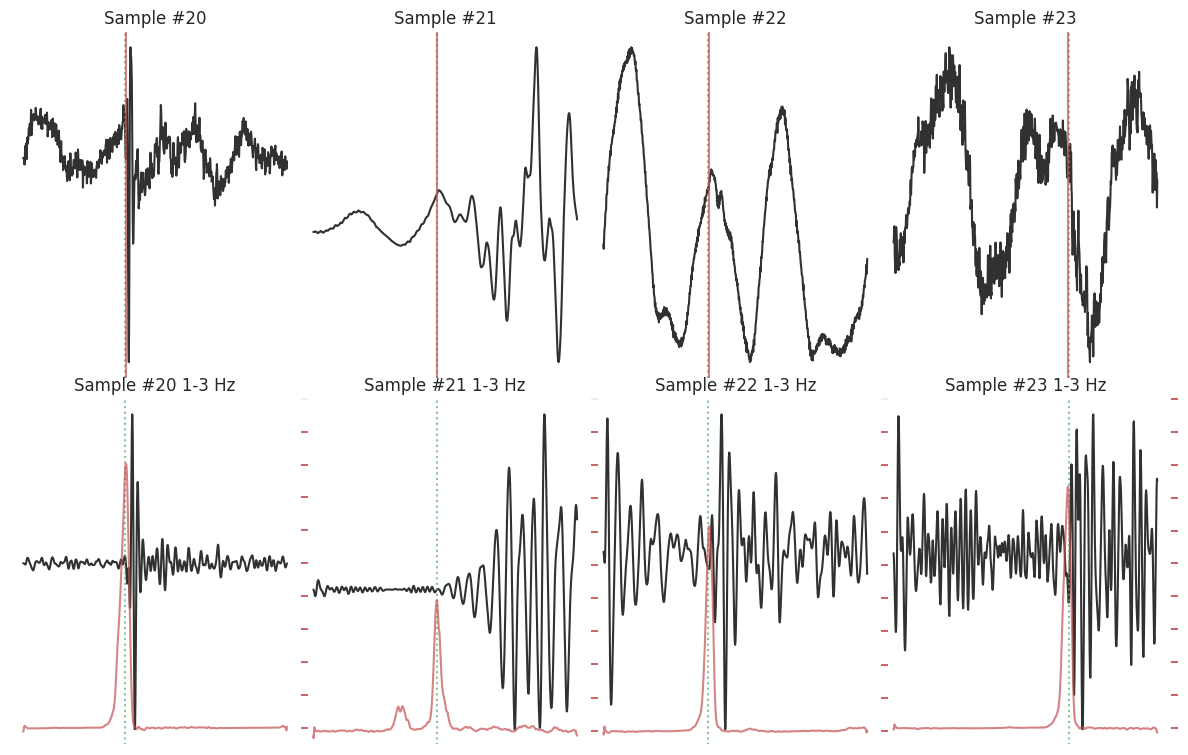

In [ ]:
visualize_predictions(model7, valid_dataset, skip=20)

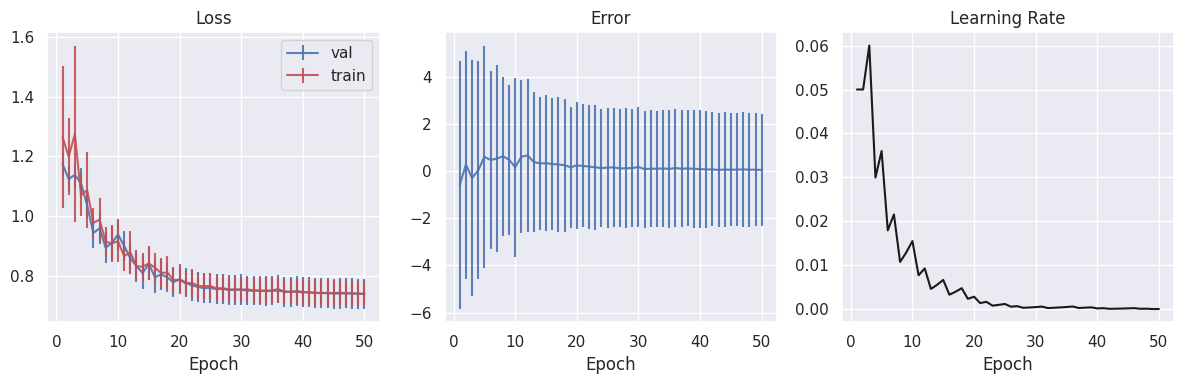

In [ ]:
model7 = train_model(
    model7,
    train_dataloader,
    valid_dataloader,
    num_epochs=50,
    save_interval=10,
    model_path=model_path)

if not SINGLE_BATCH:
    torch.save(model7, model_path)

In [ ]:
# @title Terminate the notebook
from google.colab import runtime
runtime. unassign()

# Visualize the kernels in model7

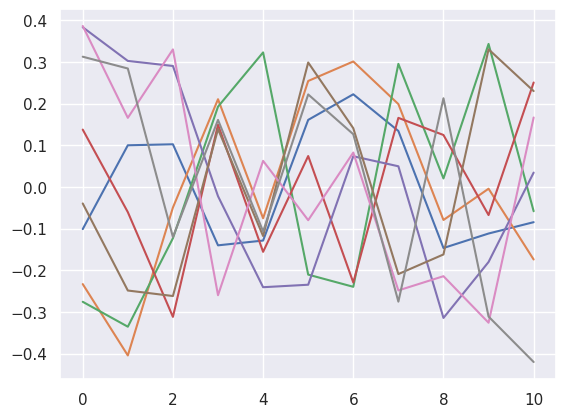

In [ ]:
for i in range(8):
  plt.plot(model7.kernels[0].weight.detach().numpy()[i,0,:])

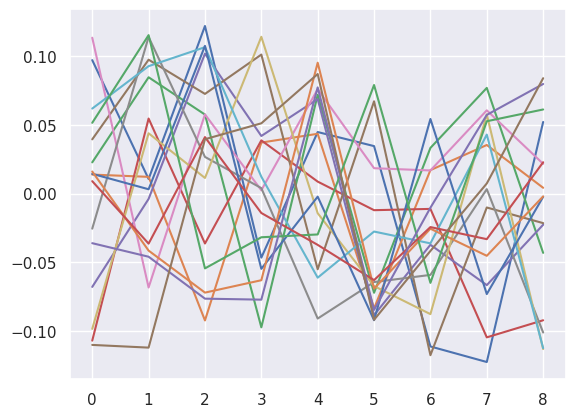

In [ ]:
for i in range(16):
  plt.plot(model7.kernels[1].weight.detach().numpy()[i,0,:])

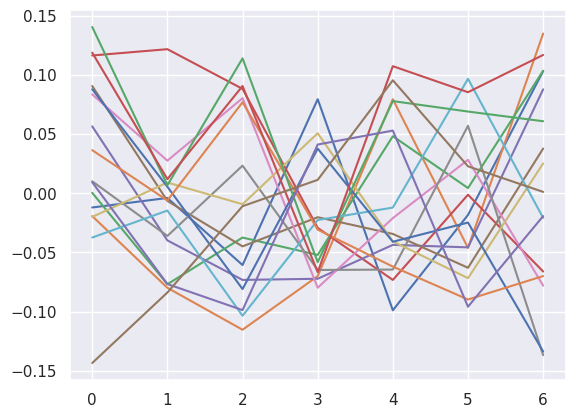

In [ ]:
for i in range(16):
  plt.plot(model7.kernels[2].weight.detach().numpy()[i,0,:])

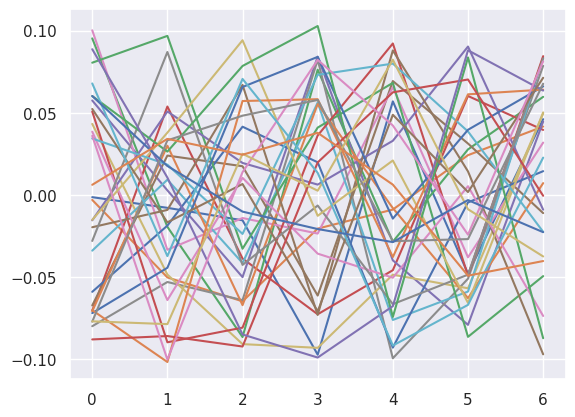

In [ ]:
for i in range(32):
  plt.plot(model7.kernels[3].weight.detach().numpy()[i,0,:])

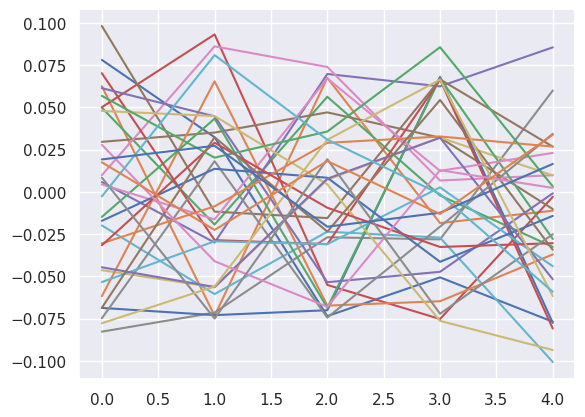

In [ ]:
for i in range(32):
  plt.plot(model7.kernels[4].weight.detach().numpy()[i,0,:])

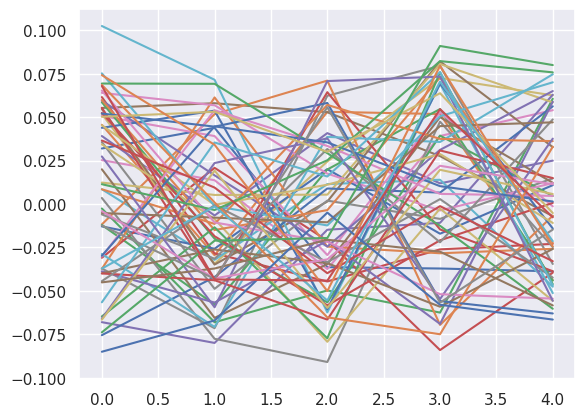

In [ ]:
for i in range(64):
  plt.plot(model7.kernels[5].weight.detach().numpy()[i,0,:])

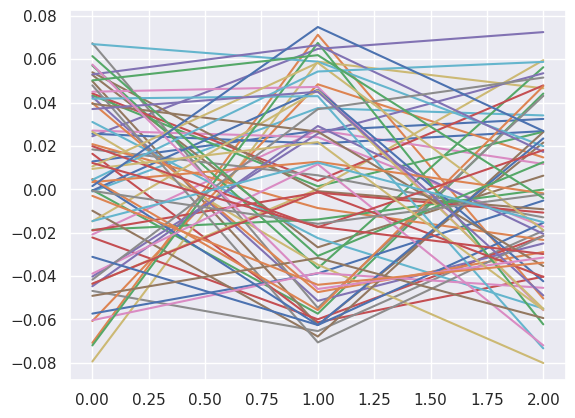

In [ ]:
for i in range(64):
  plt.plot(model7.kernels[6].weight.detach().numpy()[i,0,:])

# Thesis: What if we only used half of the number of convolutions?

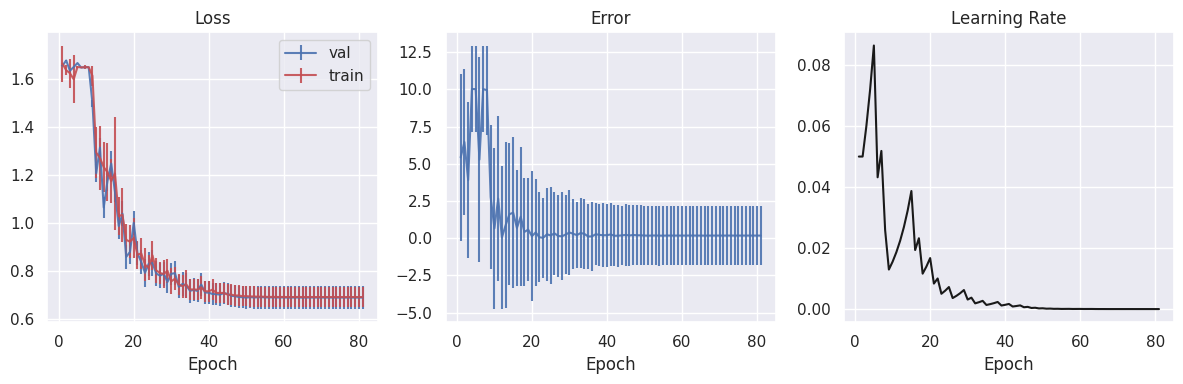

  0%|          | 0/191 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f0ee50d43a0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
# @title Train model7b or load from disk
model_path = os.path.join(HOMEDIR, "model7b.pic")
if os.path.exists(model_path):
  # model7b = torch.load(model_path)
  model7b = torch.load(model_path, map_location=torch.device(DEVICE))
else:
  model7b = MultConvRNNModel(
    input_dim=1,
    # https://www.nature.com/articles/s41467-020-17591-w/figures/1
    kernel_dims=[(8, 11), (16, 7), (32, 5), (64, 3)],
    hidden_dim=100,
    layer_dim=30).double().to(DEVICE)

  model7b = train_model(
    model7b,
    train_dataloader,
    valid_dataloader,
    num_epochs=100,
    save_interval=10,
    model_path=model_path)

  if not SINGLE_BATCH:
    torch.save(model7b, model_path)

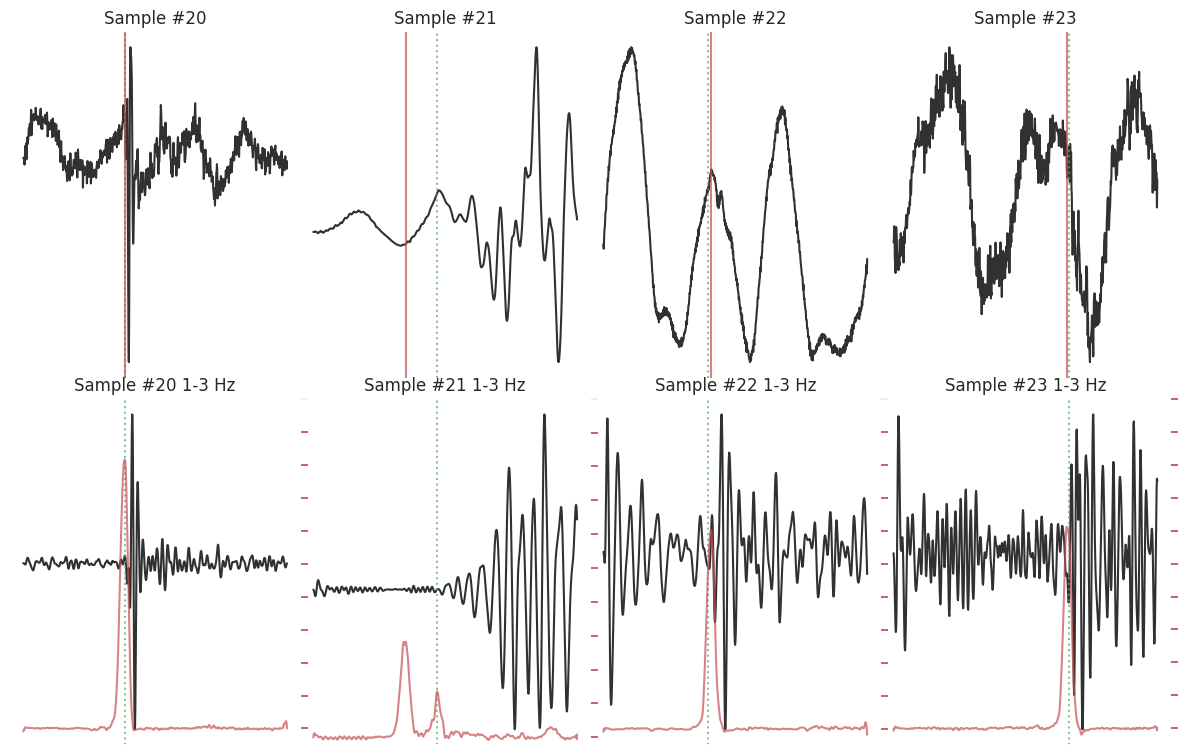

In [ ]:
visualize_predictions(model7b, valid_dataset, skip=20)

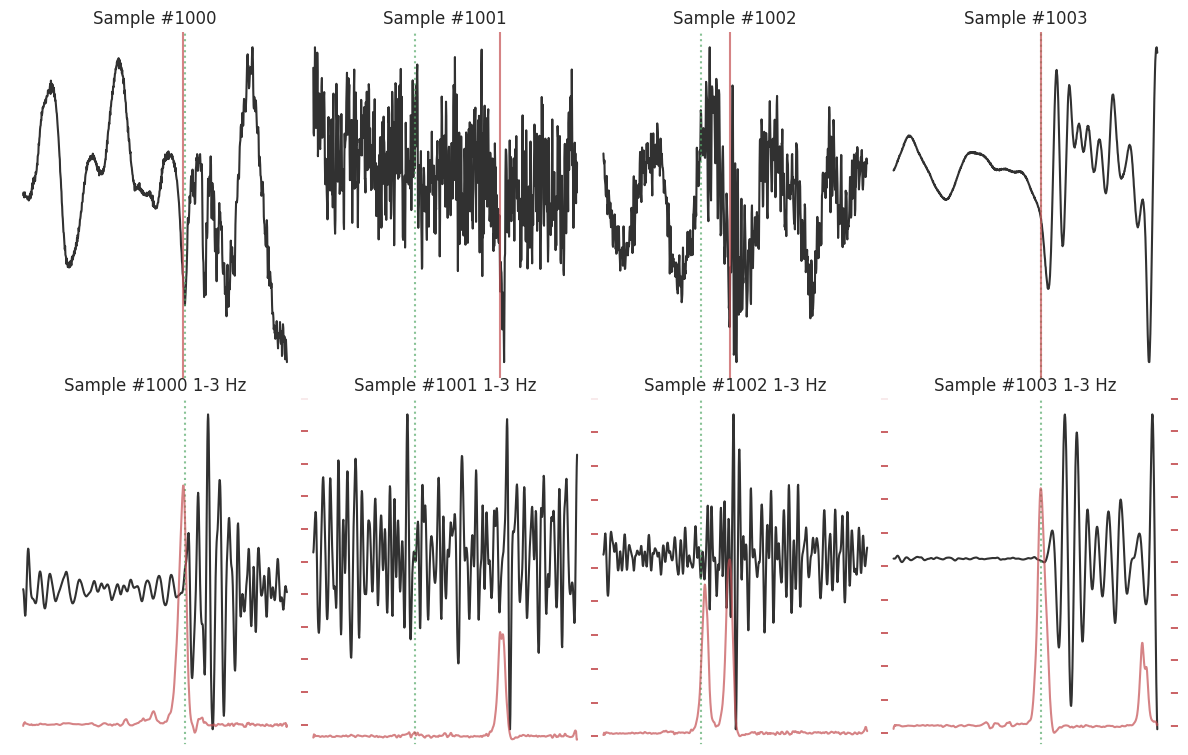

In [ ]:
visualize_predictions(model7b, valid_dataset, skip=1000)

In [ ]:
# @title Terminate the notebook
from google.colab import runtime
runtime. unassign()

# Thesis what if trained with only half of the RNN layers? model7c

In [ ]:
# @title Train model7c or load from disk
model_path = os.path.join(HOMEDIR, "model7c.pic")
if os.path.exists(model_path):
  # model7c = torch.load(model_path)
  model7c = torch.load(model_path, map_location=torch.device(DEVICE))
else:
  model7c = MultConvRNNModel(
    input_dim=1,
    # https://www.nature.com/articles/s41467-020-17591-w/figures/1
    kernel_dims=[(8, 11), (16, 7), (32, 5), (64, 3)],
    hidden_dim=100,
    layer_dim=15).double().to(DEVICE)

  model7c = train_model(
    model7c,
    train_dataloader,
    valid_dataloader,
    num_epochs=50,
    save_interval=10,
    model_path=model_path)

  if not SINGLE_BATCH:
    torch.save(model7c, model_path)

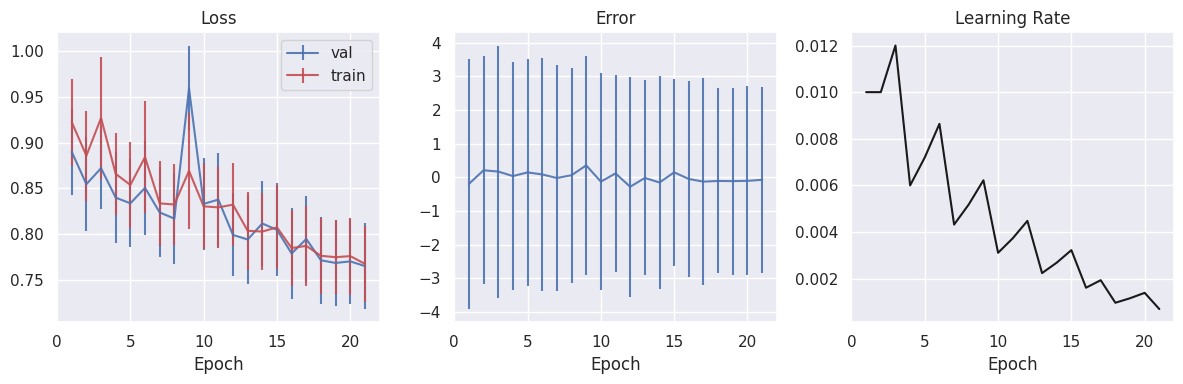

In [ ]:
train_model(
    model7c,
    train_dataloader,
    valid_dataloader,
    num_epochs=50,
    save_interval=10,
    model_path=model_path,
    learning_rate=0.01)

In [ ]:
eval_model(model7c, valid_dataloader)

In [ ]:
visualize_predictions(model7c, valid_dataset, skip=20)

In [ ]:
visualize_predictions(model7c, valid_dataset, skip=1000)

In [ ]:
# @title Terminate the notebook
from google.colab import runtime
runtime. unassign()